In [1]:
# starter libraries & functions
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from ipywidgets import interact
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

# this is to maintain same plot look
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use('fivethirtyeight')
%matplotlib inline

# file path & files
data_path = 'C:/Users/cmontevirgen/class_projects/nflstatistics/'  
rb_career = pd.read_csv(data_path + 'Career_Stats_Rushing.csv')
rb_games = pd.read_csv(data_path + 'Game_Logs_Runningback.csv')
basic_stats = pd.read_csv(data_path + 'Basic_Stats.csv')
combine = pd.read_csv(data_path + 'combine_data_since_2000_PROCESSED_2018-04-26.csv')


In [2]:
# examine columns names
print(basic_stats.columns)
print(rb_games.columns)
print(combine.columns)

Index(['Age', 'Birth Place', 'Birthday', 'College', 'Current Status',
       'Current Team', 'Experience', 'Height (inches)', 'High School',
       'High School Location', 'Name', 'Number', 'Player Id', 'Position',
       'Weight (lbs)', 'Years Played'],
      dtype='object')
Index(['Player Id', 'Name', 'Position', 'Year', 'Season', 'Week', 'Game Date',
       'Home or Away', 'Opponent', 'Outcome', 'Score', 'Games Played',
       'Games Started', 'Rushing Attempts', 'Rushing Yards', 'Yards Per Carry',
       'Longest Rushing Run', 'Rushing TDs', 'Receptions', 'Receiving Yards',
       'Yards Per Reception', 'Longest Reception', 'Receiving TDs', 'Fumbles',
       'Fumbles Lost'],
      dtype='object')
Index(['Player', 'Pos', 'Ht', 'Wt', 'Forty', 'Vertical', 'BenchReps',
       'BroadJump', 'Cone', 'Shuttle', 'Year', 'Pfr_ID', 'AV', 'Team', 'Round',
       'Pick'],
      dtype='object')


In [3]:
rb_games.describe()

,Year,Week,Games Played
count,67661.000000,67661.000000,67661.000000
mean,1996.351502,8.511447,0.881291
std,14.042810,5.292495,0.323449
min,1970.000000,0.000000,0.000000
25%,1984.000000,4.000000,1.000000
50%,1999.000000,8.000000,1.000000
75%,2009.000000,13.000000,1.000000
max,2016.000000,23.000000,1.000000


In [4]:
# remove spaces in column names
basic_stats.rename(columns={'Birth Place':'Birth_Place', 'Current Status':'Current_Status', 
                           'Current Team': 'Current_Team', 'Height (inches)': 'Height',
                           'High School':'High_School', 'High School Location':'High_School_Location',
                           'Player Id':'Player_Id', 'Weight (lbs)':'Weight', 'Years Played':'Years_Played'}, inplace=True)
rb_games.rename(columns = {'Player Id':'Player_Id', 'Game Date':'Game_Date', 
                           'Home or Away': 'Home_Away', 'Games Played': 'Games_Played',
                           'Games Started':'Games_Started', 'Rushing Attempts':'Rushing_Attempts',
                           'Rushing Yards':'Rushing_Yards', 'Yards Per Carry':'YPC', 'Longest Rushing Run':'Longest_Rush',
                          'Rushing TDs': 'Rushing_TDs', 'Receiving Yards':'Receiving_Yards', 'Yards Per Reception':'YPR',
                          'Longest Reception':'Longest_Reception','Receiving TDs':'Receiving_TDs',
                          'Fumbles Lost':'Fumbles_Lost'}, inplace=True)

In [5]:
# Note to Adam: In this section, I admitedly opened the csv file and looked because I couldn't find a quick way
# to see all of the potential data errors.

# replaced '--' values with 0
rb_games.replace('--',0, inplace = True)

In [6]:
# Convert data to numbers
# First, remove strings in data
rb_games['Longest_Rush'] = rb_games['Longest_Rush'].str.rstrip('T')
rb_games['Longest_Reception'] = rb_games['Longest_Reception'].str.rstrip('T')

# Change to intergers and floats
rb_games['Rushing_Attempts'] = rb_games.Rushing_Attempts.astype(int)
rb_games['Games_Played'] = rb_games.Games_Played.astype(int)
rb_games['Rushing_Yards'] = rb_games.Rushing_Yards.astype(int)
rb_games['YPC'] = rb_games.YPC.astype(float)
rb_games['Longest_Rush'] = rb_games.Longest_Rush.astype(float)
rb_games['Rushing_TDs'] = rb_games.Rushing_TDs.astype(int)
rb_games['Receptions'] = rb_games.Receptions.astype(int)
rb_games['Receiving_Yards'] = rb_games.Receiving_Yards.astype(int)
rb_games['YPR'] = rb_games.YPR.astype(float)
rb_games['Longest_Reception'] = rb_games.Longest_Reception.astype(float)
rb_games['Receiving_TDs'] = rb_games.Receiving_TDs.astype(int)
rb_games['Fumbles'] = rb_games.Fumbles.astype(int)
rb_games['Fumbles_Lost'] = rb_games.Fumbles_Lost.astype(int)
rb_games['Games_Started'] = rb_games.Games_Started.astype(int)
combine['Forty'] = combine.Forty.astype(float)

In [7]:
# Merge files to get more information per player. Set Player ID as index. Include only names in common to both sets
#First, add name column to 'combine' dataset to match with other datasets
combine['Name_x'] = combine.Player.apply(lambda x: ', '.join(x.split()[::-1]))

#Then,merge both files and get more information per player. Set Player ID as index
merged_rb = pd.merge(rb_games, basic_stats, on = 'Player_Id')
merged_rb = pd.merge(rb_games, basic_stats, on = 'Player_Id')
merged_rb = pd.merge(merged_rb, combine, on = 'Name_x', how = 'inner')
merged_rb.describe()

,Year_x,Week,Games_Played,Games_Started,Rushing_Attempts,Rushing_Yards,YPC,Longest_Rush,Rushing_TDs,Receptions,...,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year_y,AV,Round,Pick
count,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,12274.000000,20016.000000,20016.000000,...,19766.000000,15555.000000,15357.000000,15634.000000,12413.000000,12095.000000,20016.000000,20016.000000,16201.000000,16201.000000
mean,2008.278028,8.156325,0.833433,0.299311,5.937300,24.752048,2.461776,13.255744,0.173461,1.138289,...,4.577472,34.356316,21.949274,117.589740,7.096640,4.291144,2007.664319,11.539818,3.564657,103.963706
std,7.745302,5.550521,0.372598,0.457967,7.521322,36.228927,3.121007,12.342548,0.468745,1.725001,...,0.179276,3.440005,4.810890,7.157236,0.274291,0.179701,4.712390,11.736690,1.886052,67.420909
min,1970.000000,0.000000,0.000000,0.000000,0.000000,-9.000000,-8.000000,-8.000000,0.000000,0.000000,...,4.240000,24.500000,10.000000,96.000000,6.500000,3.890000,2000.000000,0.000000,1.000000,2.000000
25%,2006.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,...,4.460000,32.500000,19.000000,114.000000,6.880000,4.180000,2003.000000,2.000000,2.000000,45.000000
50%,2010.000000,7.000000,1.000000,0.000000,3.000000,7.000000,2.000000,10.000000,0.000000,0.000000,...,4.560000,34.500000,21.000000,118.000000,7.050000,4.250000,2008.000000,8.000000,4.000000,103.000000
75%,2014.000000,13.000000,1.000000,1.000000,10.000000,38.000000,4.000000,17.000000,0.000000,2.000000,...,4.630000,36.500000,25.000000,122.000000,7.230000,4.410000,2011.000000,20.000000,5.000000,146.000000
max,2016.000000,23.000000,1.000000,1.000000,43.000000,295.000000,97.000000,97.000000,4.000000,15.000000,...,5.400000,43.000000,37.000000,137.000000,8.000000,4.830000,2018.000000,44.000000,7.000000,257.000000


In [8]:
# Clean up dataframe

#Turn Wins/Losses/Ties into numbers
merged_rb.Outcome.replace('W',1, inplace = True)
merged_rb.Outcome.replace('L',0, inplace = True)
merged_rb.Outcome.replace('T',0, inplace = True)
merged_rb['Outcome'] = merged_rb.Outcome.astype(int)

# replace missing numbers with 0
merged_rb.fillna(0)

# although fillna above got most, NaN remains. I used an average for replacement values
merged_rb.Weight.replace(0,merged_rb.Weight.mean(), inplace = True)
merged_rb.Weight.fillna(merged_rb.Weight.mean(), inplace=True)
merged_rb.Height.fillna(merged_rb.Height.mean(), inplace=True)
merged_rb.Forty.replace(0,merged_rb.Forty.mean(), inplace = True)
merged_rb.Forty.fillna(merged_rb.Forty.mean(), inplace = True)
merged_rb.Vertical.replace(0,merged_rb.Vertical.mean(), inplace = True)
merged_rb.Vertical.fillna(merged_rb.Vertical.mean(), inplace = True)
merged_rb.BenchReps.replace(0,merged_rb.BenchReps.mean(), inplace = True)
merged_rb.BenchReps.fillna(merged_rb.BenchReps.mean(), inplace = True)
merged_rb.BroadJump.replace(0,merged_rb.BroadJump.mean(), inplace = True)
merged_rb.BroadJump.fillna(merged_rb.BroadJump.mean(), inplace = True)
merged_rb.Cone.replace(0,merged_rb.Cone.mean(), inplace = True)
merged_rb.Cone.fillna(merged_rb.Cone.mean(), inplace = True)
merged_rb.Shuttle.replace(0,merged_rb.Shuttle.mean(), inplace = True)
merged_rb.Shuttle.fillna(merged_rb.Shuttle.mean(), inplace = True)

In [9]:
# Create new dataframe that captures 'Combine' data from year 2000 on (data starts in 2000),...
# ... only regular season data (no preseason), and include players that were drafted
new_rb = merged_rb[(merged_rb.Year_x > 2000) & (merged_rb.Season == 'Regular Season') & (merged_rb.Pick > 0)]
new_rb.describe()

,Year_x,Week,Outcome,Games_Played,Games_Started,Rushing_Attempts,Rushing_Yards,YPC,Longest_Rush,Rushing_TDs,...,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year_y,AV,Round,Pick
count,11888.000000,11888.000000,11888.000000,11888.000000,11888.000000,11888.000000,11888.000000,11888.000000,7402.000000,11888.000000,...,11888.000000,11888.000000,11888.000000,11888.000000,11888.000000,11888.000000,11888.000000,11888.000000,11888.000000,11888.000000
mean,2009.800723,9.006814,0.492598,0.838661,0.351194,6.665293,28.352120,2.554997,14.388273,0.192799,...,4.540761,34.467601,22.202501,118.024184,7.082315,4.284835,2007.105148,13.420845,3.529441,102.855316
std,4.289013,5.000584,0.499966,0.367859,0.477364,8.125919,39.649175,3.158137,13.232143,0.500702,...,0.138876,2.792231,4.339202,5.870487,0.194612,0.126654,4.486265,11.991597,1.892050,67.756450
min,2001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-9.000000,-8.000000,-8.000000,0.000000,...,4.240000,26.000000,10.000000,96.000000,6.500000,3.910000,2000.000000,0.000000,1.000000,2.000000
25%,2006.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,...,4.450000,33.000000,19.000000,115.000000,6.960000,4.220000,2003.000000,3.000000,2.000000,44.000000
50%,2010.000000,9.000000,0.000000,1.000000,0.000000,3.000000,8.000000,2.200000,11.000000,0.000000,...,4.540000,34.356316,21.949274,117.589740,7.096640,4.291144,2007.000000,10.000000,4.000000,99.000000
75%,2014.000000,13.000000,1.000000,1.000000,1.000000,12.000000,46.000000,4.200000,18.000000,0.000000,...,4.600000,35.500000,24.000000,121.000000,7.096640,4.291144,2011.000000,23.000000,5.000000,146.000000
max,2016.000000,17.000000,1.000000,1.000000,1.000000,43.000000,295.000000,54.000000,97.000000,4.000000,...,5.320000,43.000000,37.000000,137.000000,7.840000,4.750000,2016.000000,44.000000,7.000000,257.000000


In [10]:
# Fantasy scoring system. This values how each running back scored in each NFL game
new_rb['FP'] = (new_rb.Rushing_Yards / 10) + (new_rb.Rushing_TDs * 6) + (new_rb.Receptions * 1) + (new_rb.Receiving_Yards / 10) + (new_rb.Receiving_TDs * 6)

# For KNN... An elite FP (Fantasy Points) player scores > 15 points. This is assigned a value of 1. The rest are assigned 0.
new_rb['Elite_FP'] = new_rb['FP'].apply(lambda x: 1 if x > 15 else 0)

#This cleans up some of the new scoring data
new_rb.Elite_FP.fillna(0, inplace=True)
new_rb.Elite_FP.replace('NaN',0, inplace = True)
new_rb['Elite_FP'] = new_rb.Elite_FP.astype(int)

print(new_rb.Elite_FP.value_counts())
print(new_rb.Elite_FP.describe())

0    9958
1    1930
Name: Elite_FP, dtype: int64
count    11888.000000
mean         0.162349
std          0.368786
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Elite_FP, dtype: float64


C:\Users\cmontevirgen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\cmontevirgen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\cmontevirgen\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pyda

                  Elite_FP        FP    Weight     Forty    Height       YPC  \
Elite_FP          1.000000  0.823440 -0.118847 -0.168396  0.001126  0.352476   
FP                0.823440  1.000000 -0.179333 -0.241517 -0.019323  0.524398   
Weight           -0.118847 -0.179333  1.000000  0.583206  0.550485 -0.200105   
Forty            -0.168396 -0.241517  0.583206  1.000000  0.095923 -0.217862   
Height            0.001126 -0.019323  0.550485  0.095923  1.000000 -0.066120   
YPC               0.352476  0.524398 -0.200105 -0.217862 -0.066120  1.000000   
Receptions        0.552057  0.705450 -0.222304 -0.192614 -0.067640  0.310788   
Receiving_Yards   0.542079  0.679464 -0.194622 -0.167693 -0.059606  0.259309   
Week              0.020612  0.021747  0.009013  0.008099 -0.001441  0.015040   
Rushing_Attempts  0.626943  0.806088 -0.131413 -0.265170  0.032423  0.441840   
Vertical          0.036455  0.066561 -0.153750 -0.435011  0.015157  0.049902   
Round            -0.276796 -0.367227  0.

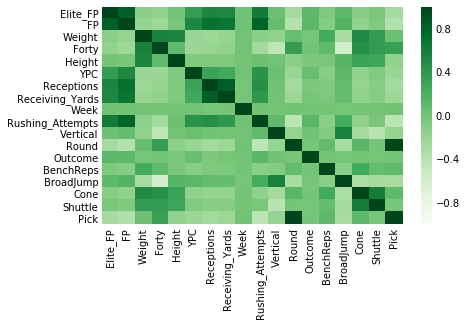

In [11]:
# Most of the EDA was done for Project 3. Here, I'll look at relationships with the new dataset (Combine)

# Goal: Try to predict/classify players that score higher fantasy points in NFL games by using Combine (pre-NFL/college) data...
# In addition to Combine data, I added the various features in each NFL game

correlations = new_rb[['Elite_FP','FP','Weight', 'Forty','Height', 'YPC', 'Receptions','Receiving_Yards','Week',
                       'Rushing_Attempts','Vertical','Round','Outcome','BenchReps','BroadJump','Cone','Shuttle','Pick']].corr()
print(correlations)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
print(sns.heatmap(correlations, cmap='Greens', vmin=-1, vmax=1))

In [12]:
# Create X and y variables. The predictors are all Combine measures plus 'Outcome' (previously defined)
predictors = ['Ht', 'Wt', 'Forty', 'Vertical', 'BenchReps', 'BroadJump', 'Cone', 'Shuttle', 'Pick', 'Outcome']

#Standardize the predictors
ss = StandardScaler()


X = new_rb[predictors]
Xs = ss.fit_transform(X) # to standardize X
y = new_rb.Elite_FP # for KNN
yLP = new_rb.FP # For linear and polynmial regression


In [13]:
# First model - traditional linear regression. Conclusion - score is not too compelling, slightly better than mean RMSE

X_train, X_test, yLP_train, yLP_test = train_test_split(X[predictors], yLP, train_size=0.7, random_state=8)

lr = LinearRegression()
lr.fit(X_train, yLP_train)
yLP_pred = lr.predict(X_test)

print('MSE - model:', np.sqrt(metrics.mean_squared_error(yLP_test, yLP_pred)))

# Measure this against mean RMSE
y_null = np.zeros_like(yLP_test, dtype=float)
y_null.fill(yLP_test.mean())
y_null
print('MSE - mean:', np.sqrt(metrics.mean_squared_error(yLP_test, y_null)))

#Measure Cross validation R2 score
linreg = LinearRegression()
linreg_scores = cross_val_score(linreg, X, yLP, cv=10, scoring = 'r2')
print('Cross validate R2 score:', np.mean(linreg_scores))

#print('R2 score:', r2_score(yLP_test, yLP_pred)) # Optional measure


MSE - model: 7.614820643154084
MSE - mean: 8.408202996812557
Cross validate R2 score: 0.1118901555248466


C:\Users\cmontevirgen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [14]:
# Second model - Lasso regression. Find the optimal lasso...

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs, y)

print(optimal_lasso.alpha_)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0074281173091454685


.............................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished


In [15]:
# Lasso continued... Cross validation. Lasso score has a slightly worse R2 score than standard linear regression

lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs, y, cv=10, scoring = 'r2')

print(lasso_scores)
print('Cross validate R2 score:', np.mean(lasso_scores))


[ 0.07953403  0.07712686  0.13079821  0.12111272  0.0772211   0.09665391
  0.0807015  -0.01768834  0.10505906 -0.03715361]
Cross validate R2 score: 0.0713365437191649


In [16]:
#... Lasso continued. Most of the variables were used, less than 1% were left out; but most have little weight
lasso.fit(Xs, y)
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print(lasso_coefs.head(20))
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(X.shape[0]))

    variable      coef  abs_coef
8       Pick -0.090189  0.090189
9    Outcome  0.036809  0.036809
1         Wt -0.032548  0.032548
2      Forty -0.004992  0.004992
6       Cone -0.003193  0.003193
3   Vertical -0.002916  0.002916
0         Ht -0.000000  0.000000
4  BenchReps -0.000000  0.000000
5  BroadJump  0.000000  0.000000
7    Shuttle  0.000000  0.000000
Percent variables zeroed out: 0.00033647375504710633


In [17]:
# (DID NOT INCLUDE IN FINAL ANLYSIS) Alternative model - polynomial regression

#X_train, X_test, yLP_train, yLP_test = train_test_split(X[predictors], yLP, train_size=0.7, random_state=8)

#poly = make_pipeline(PolynomialFeatures(degree=3), LinearRegression(fit_intercept = False))
#poly.fit(X_train, yLP_train)
#poly.score(X_test, yLP_test)

In [18]:
# Third model - KNN. Conclusion - score is only slightly higher than that of the most frequent metric

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

y_pred_class = knn.predict(X_test)
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_class))

# compare score to most frequent measure 
most_freq_class = y_train.value_counts().index[0]

y_train.value_counts()
most_freq_class

print('Most Frequent Class:', y_test.value_counts()[most_freq_class] / len(y_test))

Accuracy Score: 0.8465679676985195
Most Frequent Class: 0.8458950201884253


In [19]:
# Alternative KNN, I re-ram the model with an 'Elite FP' criteria of 5 pts (instead of 15), and the score improved...
#... The score was 75 versus 60 (most frequent measure)